In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random

In [2]:
path = "../outputs/module1_results.csv"
df = pd.read_csv(path)
df

,image_name,vehicle_count,Pedestrian_count,congestion
0,7d06fefd-f7be05a6.jpg,9,0,LOW
1,7d128593-0ccfea4c.jpg,3,0,LOW
2,7d15b18b-1e0d6e3f.jpg,6,0,LOW
3,7d209219-ccdc1a09.jpg,5,0,LOW
4,7d22891c-224788c0.jpg,3,0,LOW
...,...,...,...,...
995,abc6b442-311adbdf.jpg,2,0,LOW
996,abf6f644-ade3cfa2.jpg,5,0,LOW
997,abfbfcb1-0e220001.jpg,17,0,Medium
998,ac033a32-493865fc.jpg,10,1,Medium


In [3]:
# Extract and prepare features
feature = df[["vehicle_count", "Pedestrian_count"]].values
congestion_map = {"LOW": 0, "Medium": 1, "High": 2}
congestion_labels = df["congestion"].map(congestion_map).values

print(f"Number of samples: {len(feature)}")
print(f"Vehicle count range: {feature[:, 0].min()} - {feature[:, 0].max()}")
print(f"Pedestrian count range: {feature[:, 1].min()} - {feature[:, 1].max()}")

Number of samples: 1000
Vehicle count range: 0 - 20
Pedestrian count range: 0 - 14


In [4]:
class TrafficEnvironment:
    """
    Simplified Traffic Signal Control Environment.

    State: (vehicle_count_bucket, pedestrian_count_bucket, current_phase)
    Actions: 0=Short Green, 1=Medium Green, 2=Long Green, 3=Emergency Mode
    """

    def __init__(self, traffic_data, congestion_labels):
        self.traffic_data = traffic_data
        self.congestion_labels = congestion_labels
        self.n_samples = len(traffic_data)
        self.current_idx = 0
        self.current_phase = 0  # Current signal phase

        # Define state buckets for discretization
        self.vehicle_buckets = [0, 5, 10, 15, 20, 100]  # Bucket edges
        self.pedestrian_buckets = [0, 2, 5, 10, 50]  # Bucket edges

        # Action space: signal timing decisions
        self.n_actions = 4
        self.action_names = [
            "Short Green (10s)",
            "Medium Green (20s)",
            "Long Green (30s)",
            "Emergency Mode",
        ]

        # State space size
        self.n_vehicle_states = len(self.vehicle_buckets)
        self.n_pedestrian_states = len(self.pedestrian_buckets)
        self.n_phases = 4  # Number of signal phases

    def _discretize_state(self, vehicle_count, pedestrian_count, phase):
        """Convert continuous values to discrete state."""
        v_bucket = np.digitize(vehicle_count, self.vehicle_buckets) - 1
        p_bucket = np.digitize(pedestrian_count, self.pedestrian_buckets) - 1
        return (v_bucket, p_bucket, phase)

    def reset(self):
        """Reset environment to initial state."""
        self.current_idx = random.randint(0, self.n_samples - 1)
        self.current_phase = random.randint(0, self.n_phases - 1)
        vehicle_count, pedestrian_count = self.traffic_data[self.current_idx]
        return self._discretize_state(
            vehicle_count, pedestrian_count, self.current_phase
        )

    def step(self, action):
        """Take an action and return next state, reward, done."""
        vehicle_count, pedestrian_count = self.traffic_data[self.current_idx]
        congestion_level = self.congestion_labels[self.current_idx]

        # Calculate reward based on action and traffic conditions
        reward = self._calculate_reward(
            action, vehicle_count, pedestrian_count, congestion_level
        )

        # Move to next time step
        self.current_idx = (self.current_idx + 1) % self.n_samples
        self.current_phase = (self.current_phase + 1) % self.n_phases

        # Get next state
        next_vehicle, next_pedestrian = self.traffic_data[self.current_idx]
        next_state = self._discretize_state(
            next_vehicle, next_pedestrian, self.current_phase
        )

        done = False  # Continuous environment

        return next_state, reward, done

    def _calculate_reward(
        self, action, vehicle_count, pedestrian_count, congestion_level
    ):
        """Calculate reward based on action appropriateness."""
        reward = 0

        # High congestion scenarios
        if congestion_level == 2:  # High
            if action == 2:  # Long green - good for high traffic
                reward = 10
            elif action == 3:  # Emergency mode - acceptable
                reward = 5
            elif action == 1:  # Medium green
                reward = 0
            else:  # Short green - bad for high traffic
                reward = -10

        # Medium congestion
        elif congestion_level == 1:  # Medium
            if action == 1:  # Medium green - optimal
                reward = 10
            elif action in [0, 2]:  # Short or Long green
                reward = 5
            else:  # Emergency mode - overkill
                reward = -5

        # Low congestion
        else:  # Low
            if action == 0:  # Short green - efficient
                reward = 10
            elif action == 1:  # Medium green
                reward = 5
            else:  # Long green or Emergency - wasteful
                reward = -5

        # Bonus for considering pedestrians
        if pedestrian_count > 5 and action >= 1:
            reward += 2  # Extra time for pedestrians

        return reward


# Create environment
env = TrafficEnvironment(feature, congestion_labels)
print(f"Environment created with {env.n_actions} actions")
print(f"Actions: {env.action_names}")

Environment created with 4 actions
Actions: ['Short Green (10s)', 'Medium Green (20s)', 'Long Green (30s)', 'Emergency Mode']


In [5]:
class QLearningAgent:
    """
    Q-Learning Agent for Traffic Signal Control.
    """

    def __init__(
        self,
        n_actions,
        learning_rate=0.1,
        discount_factor=0.95,
        epsilon=1.0,
        epsilon_decay=0.995,
        epsilon_min=0.01,
    ):
        self.n_actions = n_actions
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        # Q-table as a dictionary for sparse state representation
        self.q_table = defaultdict(lambda: np.zeros(n_actions))

    def choose_action(self, state):
        """Epsilon-greedy action selection."""
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state):
        """Update Q-value using Q-learning update rule."""
        current_q = self.q_table[state][action]
        max_next_q = np.max(self.q_table[next_state])

        # Q-learning update: Q(s,a) = Q(s,a) + α * (r + γ * max(Q(s',a')) - Q(s,a))
        new_q = current_q + self.lr * (reward + self.gamma * max_next_q - current_q)
        self.q_table[state][action] = new_q

    def decay_epsilon(self):
        """Decay exploration rate."""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)


# Create agent
agent = QLearningAgent(n_actions=env.n_actions)
print(f"Q-Learning Agent created")
print(f"Initial epsilon: {agent.epsilon}")

Q-Learning Agent created
Initial epsilon: 1.0


In [6]:
def train_agent(env, agent, n_episodes=1000, steps_per_episode=100):
    """Train the Q-learning agent."""
    episode_rewards = []
    epsilon_history = []

    for episode in range(n_episodes):
        state = env.reset()
        total_reward = 0

        for step in range(steps_per_episode):
            # Choose action
            action = agent.choose_action(state)

            # Take action
            next_state, reward, done = env.step(action)

            # Learn from experience
            agent.learn(state, action, reward, next_state)

            total_reward += reward
            state = next_state

        # Decay epsilon after each episode
        agent.decay_epsilon()

        episode_rewards.append(total_reward)
        epsilon_history.append(agent.epsilon)

        # Print progress
        if (episode + 1) % 100 == 0:
            avg_reward = np.mean(episode_rewards[-100:])
            print(
                f"Episode {episode + 1}/{n_episodes} - Avg Reward: {avg_reward:.2f}, Epsilon: {agent.epsilon:.3f}"
            )

    return episode_rewards, epsilon_history

In [7]:
# Train the agent
print("Training Q-Learning Agent...")
print("=" * 50)
episode_rewards, epsilon_history = train_agent(
    env, agent, n_episodes=1000, steps_per_episode=100
)
print("=" * 50)
print("Training completed!")

Training Q-Learning Agent...
Episode 100/1000 - Avg Reward: 324.08, Epsilon: 0.606
Episode 200/1000 - Avg Reward: 562.39, Epsilon: 0.367
Episode 300/1000 - Avg Reward: 692.02, Epsilon: 0.222
Episode 400/1000 - Avg Reward: 796.47, Epsilon: 0.135
Episode 500/1000 - Avg Reward: 864.44, Epsilon: 0.082
Episode 600/1000 - Avg Reward: 894.02, Epsilon: 0.049
Episode 700/1000 - Avg Reward: 913.63, Epsilon: 0.030
Episode 800/1000 - Avg Reward: 928.95, Epsilon: 0.018
Episode 900/1000 - Avg Reward: 937.64, Epsilon: 0.011
Episode 1000/1000 - Avg Reward: 938.24, Epsilon: 0.010
Training completed!


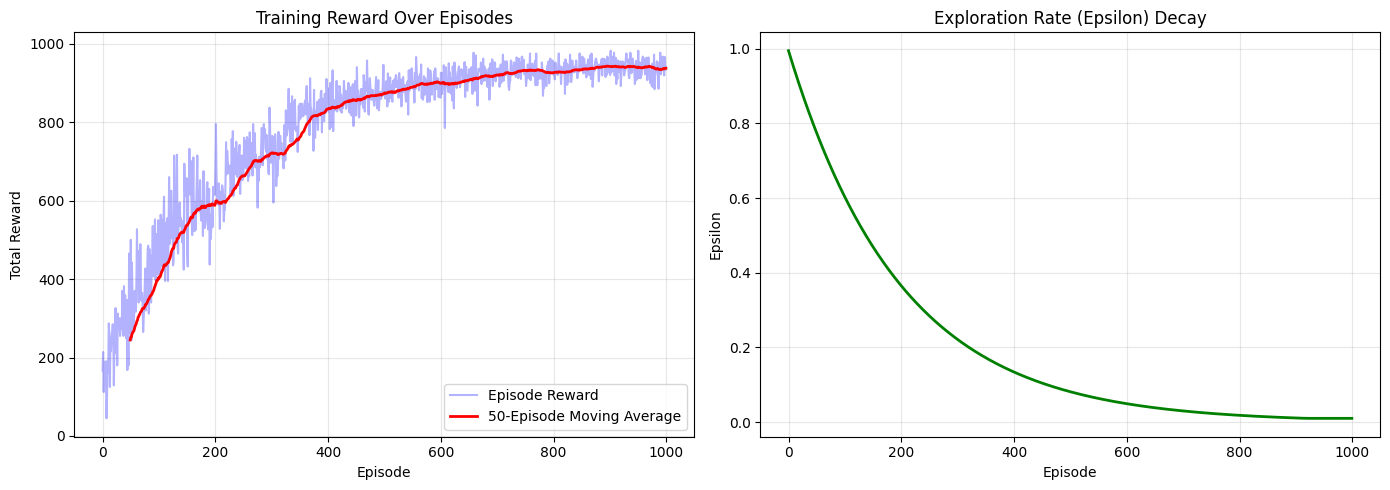

In [8]:
# Plot training progress
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Episode Rewards
axes[0].plot(episode_rewards, alpha=0.3, color="blue", label="Episode Reward")
# Rolling average
window = 50
rolling_avg = pd.Series(episode_rewards).rolling(window=window).mean()
axes[0].plot(
    rolling_avg, color="red", linewidth=2, label=f"{window}-Episode Moving Average"
)
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Total Reward")
axes[0].set_title("Training Reward Over Episodes")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Epsilon Decay
axes[1].plot(epsilon_history, color="green", linewidth=2)
axes[1].set_xlabel("Episode")
axes[1].set_ylabel("Epsilon")
axes[1].set_title("Exploration Rate (Epsilon) Decay")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("training_progress.png", dpi=150)
plt.show()

In [9]:
def evaluate_policy(env, agent, n_episodes=100, steps_per_episode=100):
    """Evaluate the learned policy without exploration."""
    original_epsilon = agent.epsilon
    agent.epsilon = 0  # Pure exploitation

    rewards = []
    action_counts = defaultdict(int)

    for episode in range(n_episodes):
        state = env.reset()
        total_reward = 0

        for step in range(steps_per_episode):
            action = agent.choose_action(state)
            action_counts[action] += 1
            next_state, reward, done = env.step(action)
            total_reward += reward
            state = next_state

        rewards.append(total_reward)

    agent.epsilon = original_epsilon
    return rewards, action_counts


# Evaluate
eval_rewards, action_counts = evaluate_policy(env, agent)

print("=" * 50)
print("Policy Evaluation Results")
print("=" * 50)
print(f"Average Reward: {np.mean(eval_rewards):.2f}")
print(f"Std Deviation: {np.std(eval_rewards):.2f}")
print(f"Min Reward: {np.min(eval_rewards)}")
print(f"Max Reward: {np.max(eval_rewards)}")
print("\nAction Distribution:")
total_actions = sum(action_counts.values())
for action, count in sorted(action_counts.items()):
    percentage = (count / total_actions) * 100
    print(f"  {env.action_names[action]}: {count} ({percentage:.1f}%)")

Policy Evaluation Results
Average Reward: 946.39
Std Deviation: 16.95
Min Reward: 902
Max Reward: 980

Action Distribution:
  Short Green (10s): 6950 (69.5%)
  Medium Green (20s): 2786 (27.9%)
  Long Green (30s): 228 (2.3%)
  Emergency Mode: 36 (0.4%)


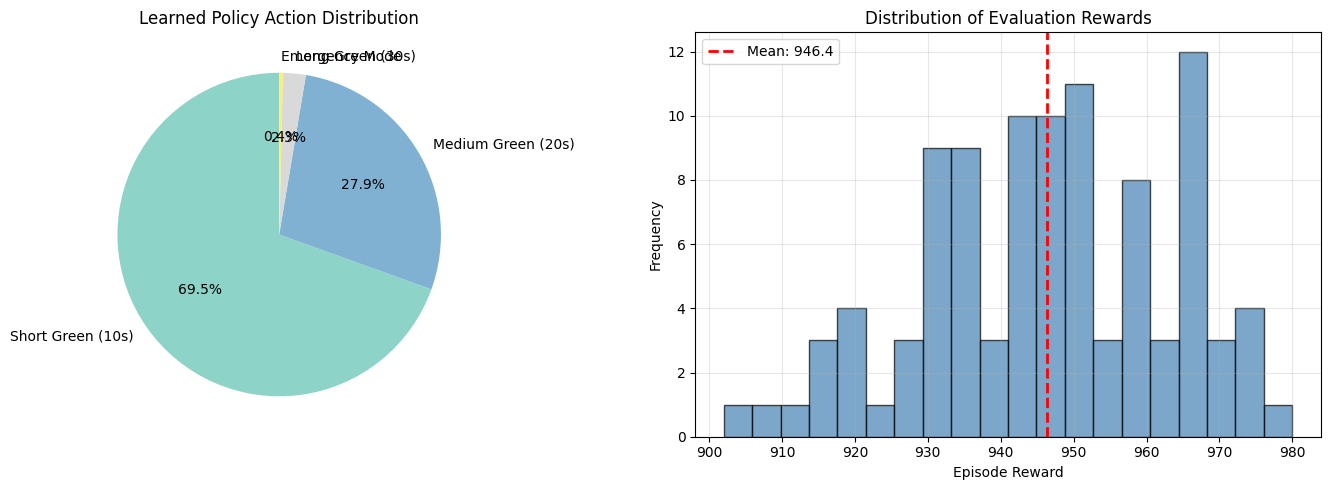

In [10]:
# Visualize action distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Action Distribution Pie Chart
actions = [env.action_names[i] for i in sorted(action_counts.keys())]
counts = [action_counts[i] for i in sorted(action_counts.keys())]
colors = plt.cm.Set3(np.linspace(0, 1, len(actions)))

axes[0].pie(counts, labels=actions, autopct="%1.1f%%", colors=colors, startangle=90)
axes[0].set_title("Learned Policy Action Distribution")

# Evaluation Rewards Histogram
axes[1].hist(eval_rewards, bins=20, edgecolor="black", alpha=0.7, color="steelblue")
axes[1].axvline(
    np.mean(eval_rewards),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {np.mean(eval_rewards):.1f}",
)
axes[1].set_xlabel("Episode Reward")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Distribution of Evaluation Rewards")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("policy_evaluation.png", dpi=150)
plt.show()

In [11]:
# Analyze Q-table
print("=" * 50)
print("Q-Table Analysis")
print("=" * 50)
print(f"Number of states visited: {len(agent.q_table)}")

# Sample Q-values for different states
print("\nSample Q-values (first 10 states):")
for i, (state, q_values) in enumerate(list(agent.q_table.items())[:10]):
    best_action = np.argmax(q_values)
    print(
        f"  State {state}: Q-values = {np.round(q_values, 2)}, Best Action: {env.action_names[best_action]}"
    )

Q-Table Analysis
Number of states visited: 52

Sample Q-values (first 10 states):
  State (np.int64(1), np.int64(0), 0): Q-values = [189.11 180.73 169.78 169.75], Best Action: Short Green (10s)
  State (np.int64(2), np.int64(0), 1): Q-values = [178.13 189.39 174.38 165.62], Best Action: Medium Green (20s)
  State (np.int64(1), np.int64(0), 2): Q-values = [188.78 181.72 172.19 172.29], Best Action: Short Green (10s)
  State (np.int64(1), np.int64(1), 3): Q-values = [169.44 183.36 154.44 161.32], Best Action: Medium Green (20s)
  State (np.int64(0), np.int64(0), 1): Q-values = [189.54 182.08 169.81 172.58], Best Action: Short Green (10s)
  State (np.int64(0), np.int64(0), 2): Q-values = [188.96 181.41 171.83 171.34], Best Action: Short Green (10s)
  State (np.int64(0), np.int64(0), 3): Q-values = [189.13 180.22 171.08 170.45], Best Action: Short Green (10s)
  State (np.int64(1), np.int64(0), 1): Q-values = [189.46 180.35 170.14 171.07], Best Action: Short Green (10s)
  State (np.int64(0)

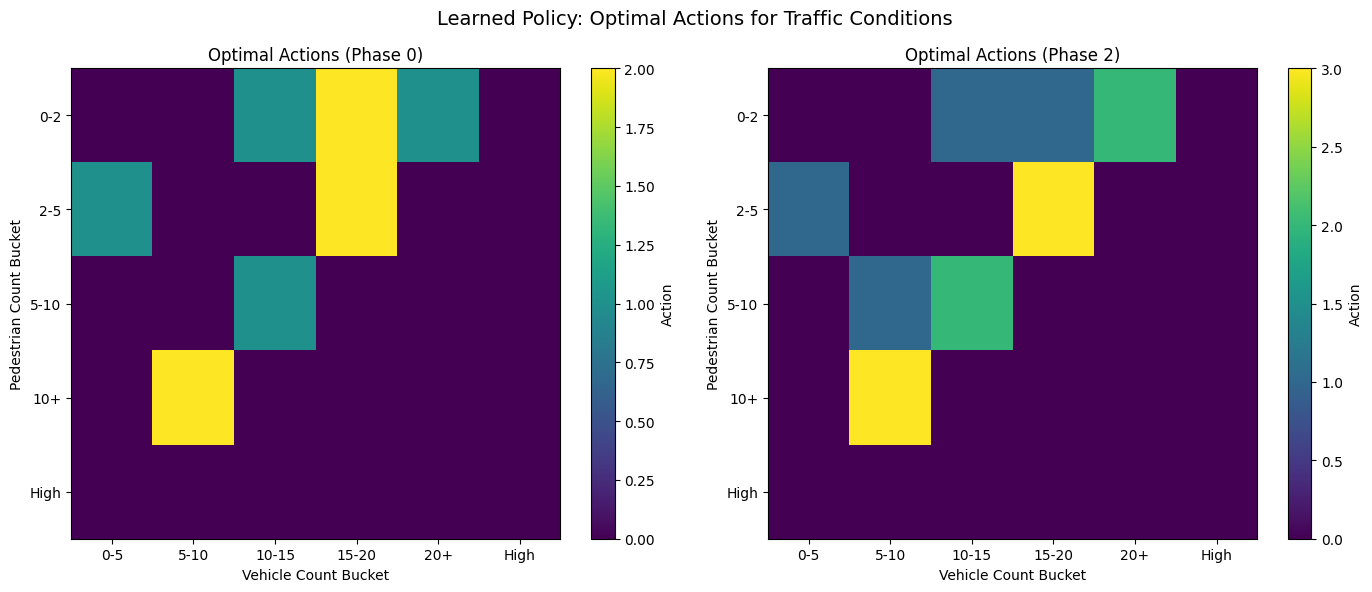

In [12]:
# Visualize optimal actions for different traffic conditions
def get_optimal_policy_grid(agent, env, phase=0):
    """Create a grid of optimal actions for visualization."""
    vehicle_range = range(0, 6)  # Bucket indices
    pedestrian_range = range(0, 5)  # Bucket indices

    policy_grid = np.zeros((len(pedestrian_range), len(vehicle_range)))

    for v in vehicle_range:
        for p in pedestrian_range:
            state = (v, p, phase)
            if state in agent.q_table:
                optimal_action = np.argmax(agent.q_table[state])
            else:
                optimal_action = 0  # Default
            policy_grid[p, v] = optimal_action

    return policy_grid


# Create policy visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for idx, phase in enumerate([0, 2]):
    policy_grid = get_optimal_policy_grid(agent, env, phase)

    im = axes[idx].imshow(policy_grid, cmap="viridis", aspect="auto")
    axes[idx].set_xlabel("Vehicle Count Bucket")
    axes[idx].set_ylabel("Pedestrian Count Bucket")
    axes[idx].set_title(f"Optimal Actions (Phase {phase})")
    axes[idx].set_xticks(range(6))
    axes[idx].set_xticklabels(["0-5", "5-10", "10-15", "15-20", "20+", "High"])
    axes[idx].set_yticks(range(5))
    axes[idx].set_yticklabels(["0-2", "2-5", "5-10", "10+", "High"])
    plt.colorbar(im, ax=axes[idx], label="Action")

plt.suptitle("Learned Policy: Optimal Actions for Traffic Conditions", fontsize=14)
plt.tight_layout()
plt.savefig("policy_visualization.png", dpi=150)
plt.show()

In [13]:
# Compare with random policy
def random_policy_evaluation(env, n_episodes=100, steps_per_episode=100):
    """Evaluate a random policy for comparison."""
    rewards = []

    for episode in range(n_episodes):
        state = env.reset()
        total_reward = 0

        for step in range(steps_per_episode):
            action = random.randint(0, env.n_actions - 1)
            next_state, reward, done = env.step(action)
            total_reward += reward
            state = next_state

        rewards.append(total_reward)

    return rewards


random_rewards = random_policy_evaluation(env)

print("=" * 50)
print("Policy Comparison")
print("=" * 50)
print(
    f"Learned Policy - Average Reward: {np.mean(eval_rewards):.2f} (±{np.std(eval_rewards):.2f})"
)
print(
    f"Random Policy  - Average Reward: {np.mean(random_rewards):.2f} (±{np.std(random_rewards):.2f})"
)
print(
    f"\nImprovement: {((np.mean(eval_rewards) - np.mean(random_rewards)) / abs(np.mean(random_rewards))) * 100:.1f}%"
)

Policy Comparison
Learned Policy - Average Reward: 946.39 (±16.95)
Random Policy  - Average Reward: 183.17 (±70.08)

Improvement: 416.7%


C:\Users\Muhammad Umer\AppData\Local\Temp\ipykernel_33704\2832301504.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


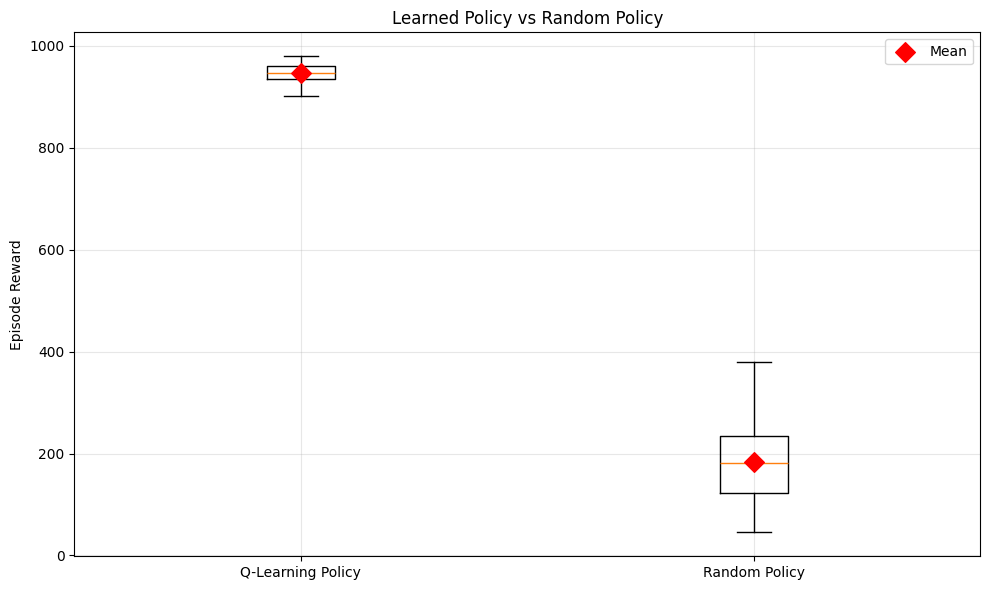

In [14]:
# Visualize comparison
plt.figure(figsize=(10, 6))

plt.boxplot(
    [eval_rewards, random_rewards], labels=["Q-Learning Policy", "Random Policy"]
)
plt.ylabel("Episode Reward")
plt.title("Learned Policy vs Random Policy")
plt.grid(True, alpha=0.3)

# Add mean markers
means = [np.mean(eval_rewards), np.mean(random_rewards)]
plt.scatter([1, 2], means, color="red", marker="D", s=100, zorder=5, label="Mean")
plt.legend()

plt.tight_layout()
plt.savefig("policy_comparison.png", dpi=150)
plt.show()

In [15]:
import pickle

# Save Q-table
q_table_dict = dict(agent.q_table)
with open("traffic_qlearning_policy.pkl", "wb") as f:
    pickle.dump(q_table_dict, f)

print("Q-Learning policy saved to 'traffic_qlearning_policy.pkl'")

Q-Learning policy saved to 'traffic_qlearning_policy.pkl'


In [16]:
# Save training results
results_df = pd.DataFrame(
    {
        "episode": range(1, len(episode_rewards) + 1),
        "reward": episode_rewards,
        "epsilon": epsilon_history,
    }
)
results_df.to_csv("training_results.csv", index=False)
print("Training results saved to 'training_results.csv'")

Training results saved to 'training_results.csv'


In [17]:
# Final Summary
print("\n" + "=" * 60)
print("MODULE 5: REINFORCEMENT LEARNING - SUMMARY")
print("=" * 60)
print(f"\nEnvironment: Traffic Signal Control")
print(f"Algorithm: Q-Learning")
print(f"Training Episodes: 1000")
print(f"Steps per Episode: 100")
print(f"\nFinal Performance:")
print(f"  - Average Episode Reward: {np.mean(eval_rewards):.2f}")
print(
    f"  - Improvement over Random: {((np.mean(eval_rewards) - np.mean(random_rewards)) / abs(np.mean(random_rewards))) * 100:.1f}%"
)
print(f"  - States Learned: {len(agent.q_table)}")
print(f"\nOutput Files:")
print(f"  - training_progress.png")
print(f"  - policy_evaluation.png")
print(f"  - policy_visualization.png")
print(f"  - policy_comparison.png")
print(f"  - traffic_qlearning_policy.pkl")
print(f"  - training_results.csv")
print("=" * 60)


MODULE 5: REINFORCEMENT LEARNING - SUMMARY

Environment: Traffic Signal Control
Algorithm: Q-Learning
Training Episodes: 1000
Steps per Episode: 100

Final Performance:
  - Average Episode Reward: 946.39
  - Improvement over Random: 416.7%
  - States Learned: 52

Output Files:
  - training_progress.png
  - policy_evaluation.png
  - policy_visualization.png
  - policy_comparison.png
  - traffic_qlearning_policy.pkl
  - training_results.csv
